# Age-Driven Service Pressure

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.dpi"] = 227
sns.set_style("whitegrid")

In [13]:
enrol= pd.read_parquet("/Users/mrehanansari/Documents/UIDAI/data/parquet/enrol_clean.parquet")
demo= pd.read_parquet("/Users/mrehanansari/Documents/UIDAI/data/parquet/demo_clean.parquet")
bio= pd.read_parquet("/Users/mrehanansari/Documents/UIDAI/data/parquet/bio_clean.parquet")

In [16]:
print("Enrol:", enrol.columns.tolist())
print("Demo :", demo.columns.tolist())
print("Bio  :", bio.columns.tolist())

Enrol: ['Unnamed: 0', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17', 'age_18_greater', 'total_enrolments']
Demo : ['Unnamed: 0', 'state', 'district', 'pincode', 'demo_age_5_17', 'demo_age_17_', 'demo_activity']
Bio  : ['Unnamed: 0', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_', 'bio_activity']


In [17]:
enrol.drop(columns= ['Unnamed: 0'], inplace= True)
demo.drop(columns= ['Unnamed: 0'], inplace= True)
bio.drop(columns= ['Unnamed: 0'], inplace= True)

In [18]:
print("Enrol:", enrol.columns.tolist())
print("Demo :", demo.columns.tolist())
print("Bio  :", bio.columns.tolist())

Enrol: ['state', 'district', 'pincode', 'age_0_5', 'age_5_17', 'age_18_greater', 'total_enrolments']
Demo : ['state', 'district', 'pincode', 'demo_age_5_17', 'demo_age_17_', 'demo_activity']
Bio  : ['state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_', 'bio_activity']


In [19]:
demo["activity_5_17"] = demo["demo_age_5_17"]
demo["activity_17_plus"] = demo["demo_age_17_"]

bio["activity_5_17"] = bio["bio_age_5_17"]
bio["activity_17_plus"] = bio["bio_age_17_"]

In [20]:
demo_dist = (
    demo.groupby(["state", "district"], as_index=False)[
        ["activity_5_17", "activity_17_plus"]
    ].sum()
)

bio_dist = (
    bio.groupby(["state", "district"], as_index=False)[
        ["activity_5_17", "activity_17_plus"]
    ].sum()
)

In [21]:
district_df = (
    demo_dist
    .merge(bio_dist, on=["state", "district"], suffixes=("_demo", "_bio"))
)

district_df["activity_5_17"] = (
    district_df["activity_5_17_demo"] +
    district_df["activity_5_17_bio"]
)

district_df["activity_17_plus"] = (
    district_df["activity_17_plus_demo"] +
    district_df["activity_17_plus_bio"]
)

district_df = district_df[
    ["state", "district", "activity_5_17", "activity_17_plus"]
]

district_df.head()

,state,district,activity_5_17,activity_17_plus
0,Andaman & Nicobar Islands,Andamans,350,2415
1,Andaman & Nicobar Islands,Nicobars,1,5
2,Andaman & Nicobar Islands,South Andaman,67,605
3,Andaman and Nicobar Islands,Nicobar,1050,1548
4,Andaman and Nicobar Islands,North And Middle Andaman,3892,4500


## Core Metric: Age-Skew Ratio

In [22]:
district_df["total_update_activity"] = (
    district_df["activity_5_17"] +
    district_df["activity_17_plus"]
)

district_df["age_17_plus_share"] = (
    district_df["activity_17_plus"] /
    district_df["total_update_activity"].replace(0, np.nan)
)

In [23]:
district_df["age_17_plus_share"].describe()

count    1053.000000
mean        0.710278
std         0.133225
min         0.268844
25%         0.614835
50%         0.700705
75%         0.794591
max         1.000000
Name: age_17_plus_share, dtype: float64

In [54]:
MIN_ACTIVITY = district_df["total_update_activity"].quantile(0.75)  # or 0.8

filtered = district_df[
    district_df["total_update_activity"] >= MIN_ACTIVITY
]

In [55]:
threshold = filtered["age_17_plus_share"].quantile(0.90)

age_skewed = (
    filtered[
        filtered["age_17_plus_share"] >= threshold
    ]
    .sort_values("age_17_plus_share", ascending=False)
)

In [56]:
age_skewed.head()

,state,district,activity_5_17,activity_17_plus,total_update_activity,age_17_plus_share
1038,West Bengal,Uttar Dinajpur,50299,311689,361988,0.861048
1009,West Bengal,Jalpaiguri,40638,227516,268154,0.848453
1014,West Bengal,Kolkata,30371,167115,197486,0.846212
188,Chhattisgarh,Mahasamund,38953,195803,234756,0.834070
194,Chhattisgarh,Raigarh,44819,213243,258062,0.826325


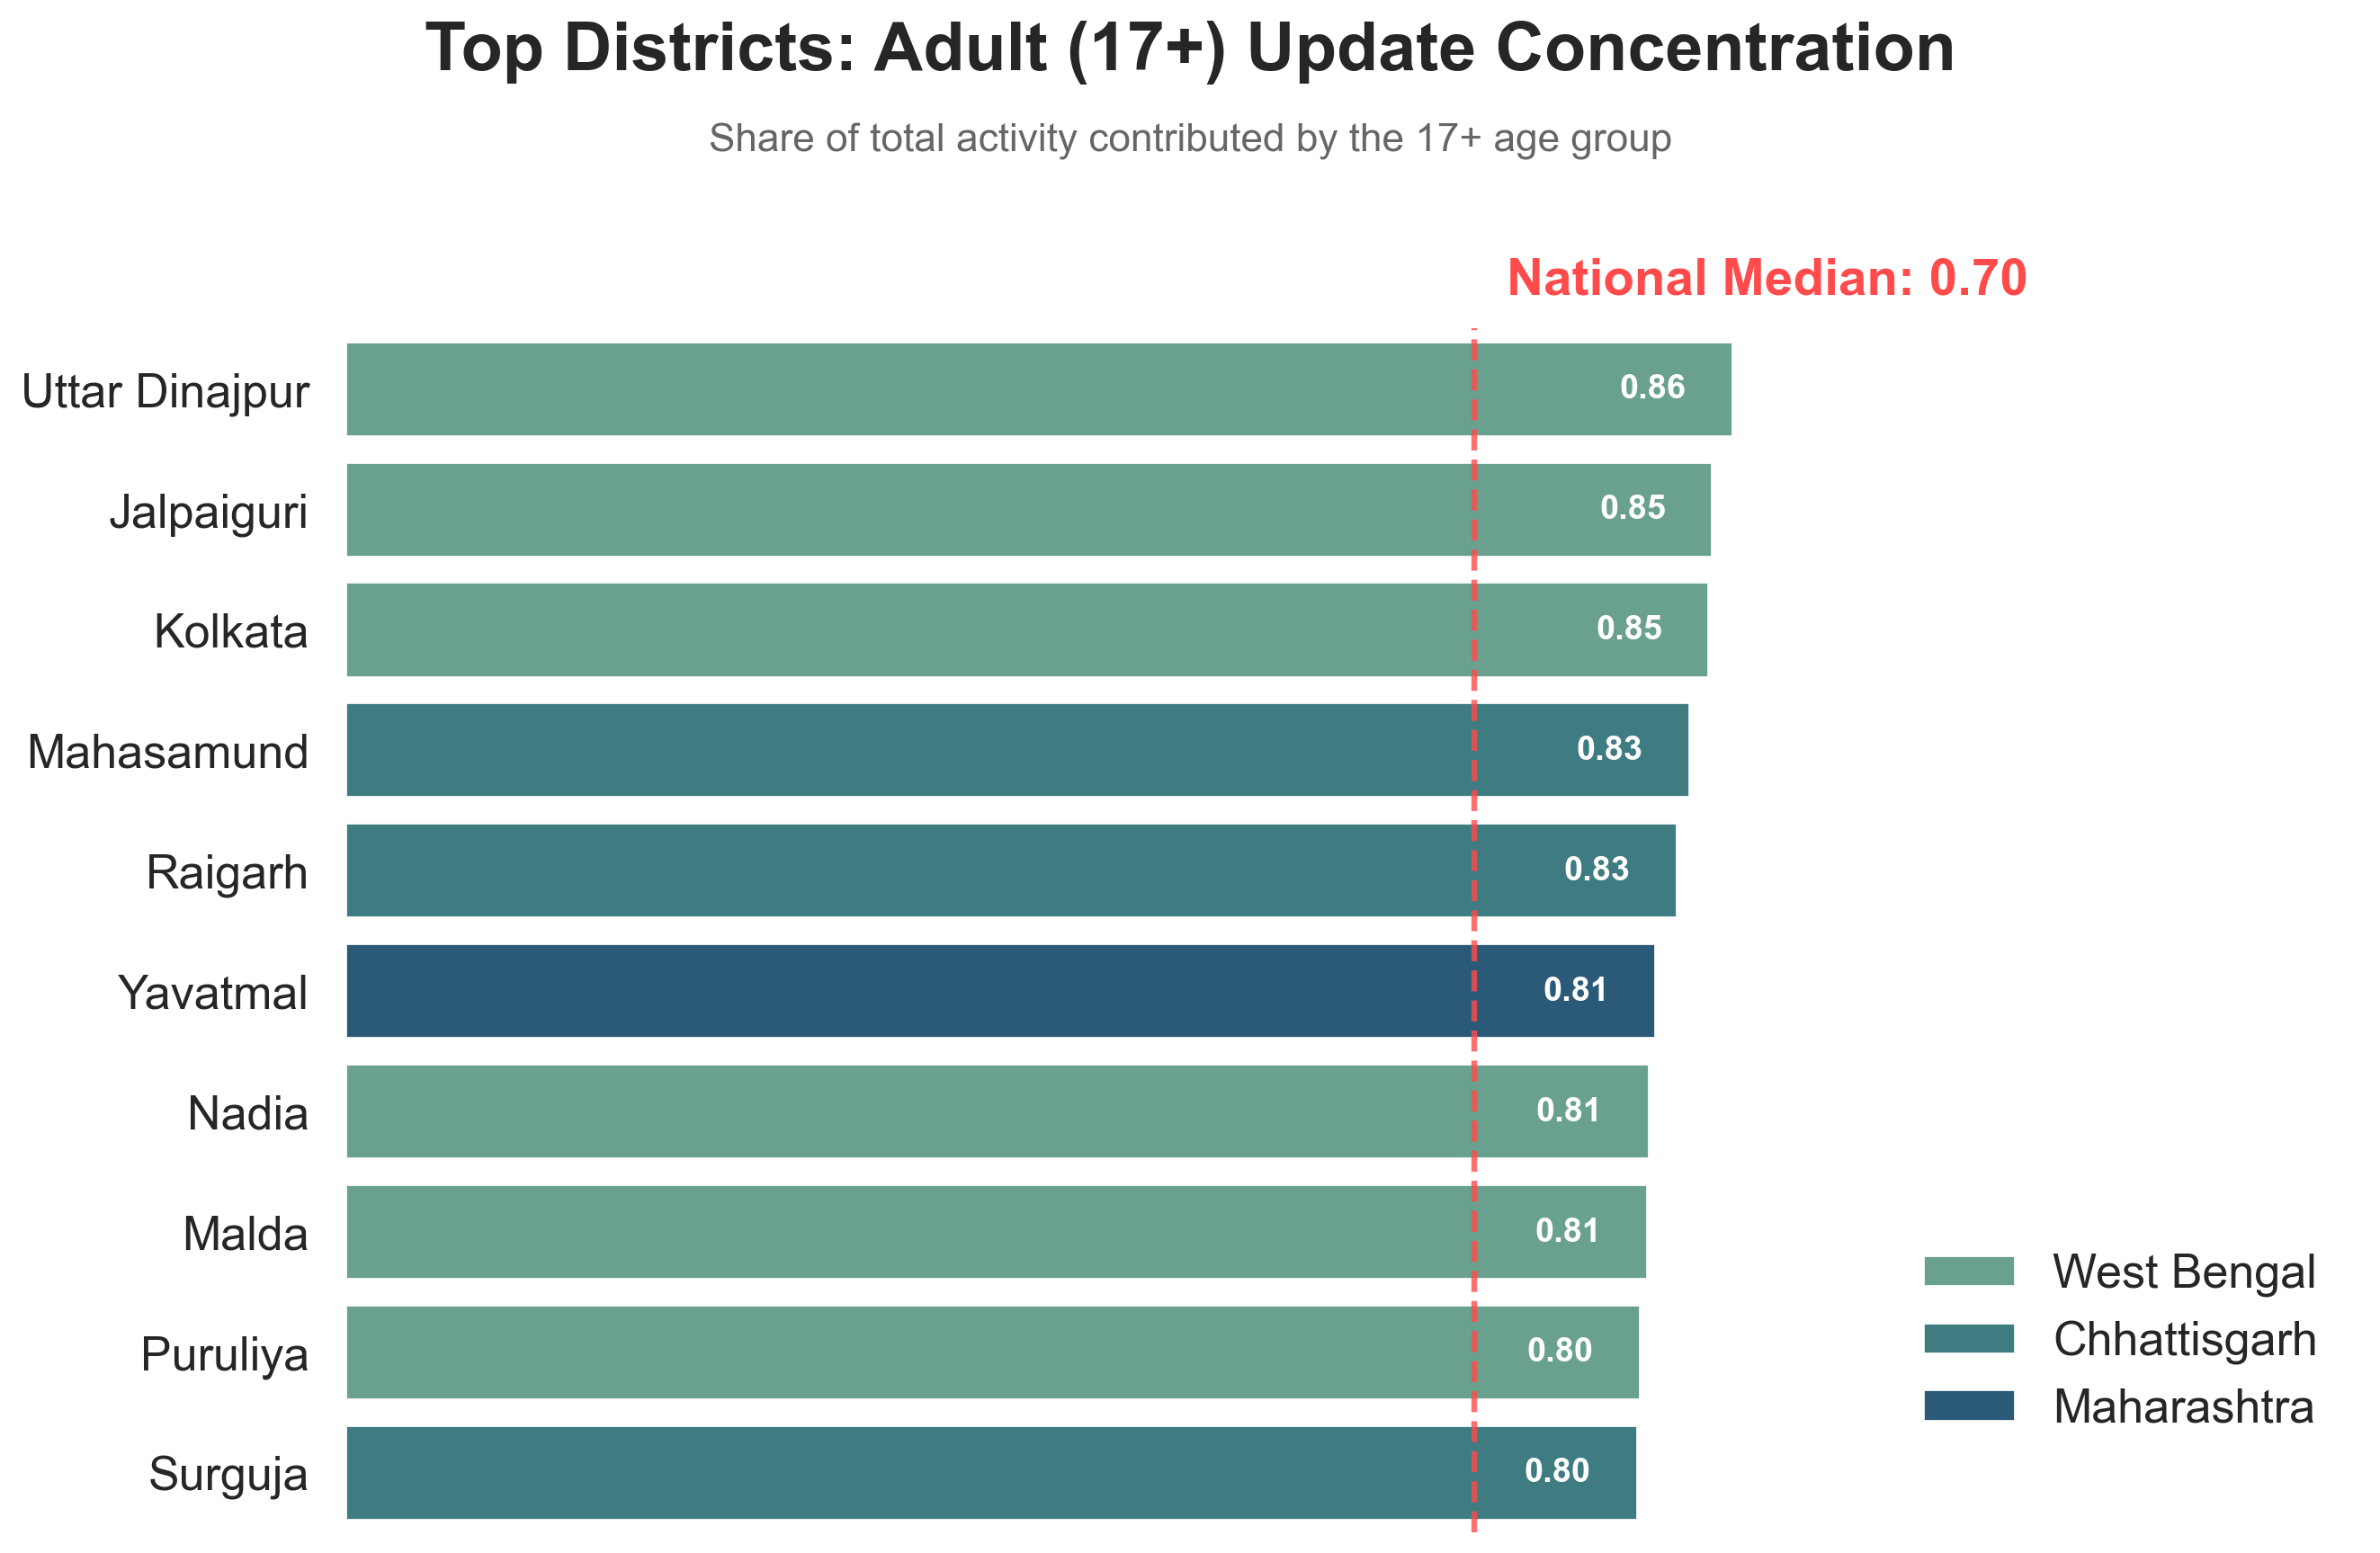

In [63]:
sns.set_context("talk")
sns.set_style("white")

# 1. Setup Figure
plt.figure(figsize=[12, 8], dpi=227)

# 2. PREPARE & SORT
top10_age = age_skewed.head(10).copy()
top10_age = top10_age.sort_values("age_17_plus_share", ascending=False)

# (Ensure you have your full dataframe 'district_df' or similar for this calc)
# If 'district_df' is not available, replace it with your full source dataframe
median_val = district_df["age_17_plus_share"].median()

# 3. PLOT
ax = sns.barplot(
    data=top10_age,
    y="district",
    x="age_17_plus_share",
    hue="state",
    palette="crest",
    dodge=False
)

# --- FIX 1: THE MEDIAN LINE & TEXT ---
plt.axvline(
    median_val,
    color="#FF4B4B",
    linestyle="--",
    linewidth=2,
    alpha=0.8
)

# CHANGED: y=-0.7 puts the text ABOVE the first bar (which is at y=0).
# This prevents it from overlapping the bar or the label.
plt.text(x=median_val + 0.02, y=-0.9, s=f"National Median: {median_val:.2f}", 
         color="#FF4B4B", weight="bold", ha="left", va="center")

# --- FIX 2: CREATE 'BREATHING ROOM' FOR LEGEND ---
plt.xlim(0, 1.25)

# 4. TITLES
plt.figtext(0.5, 0.93, "Top Districts: Adult (17+) Update Concentration", 
            fontsize=24, weight='bold', ha='center')
plt.figtext(0.5, 0.88, "Share of total activity contributed by the 17+ age group", 
            fontsize=14, color='#666666', ha='center')

# 5. DATA LABELS
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=-40, fontsize=12, color='white', weight='bold')

# 6. CLEANUP
plt.xlabel("")
plt.ylabel("")
plt.xticks([]) 
sns.despine(left=True, bottom=True)

# --- FIX 3: LEGEND PLACEMENT ---
sns.move_legend(
    ax, "lower right",
    bbox_to_anchor=(1, 0.05),
    title="",
    frameon=False,
)

# 7. LAYOUT
plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.show()

## Insight: Age-Driven Service Pressure

While Aadhaar update activity is expected to be higher in the 17+ age group, district-level patterns reveal **significant variation in the degree of adult concentration**.

Across all districts, the **national median share of 17+ update activity is approximately 70%**. However, among districts with **high total update volume**, several exhibit **substantially higher concentration (≈80–86%)**, indicating that identity maintenance activity in these regions is **structurally adult-centric** rather than evenly distributed across life stages.

This pattern suggests that Aadhaar updates in such districts tend to occur **later and in more concentrated phases**, which has implications for:
- timing of service demand,
- staffing and capacity planning,
- and targeted, age-aware outreach strategies.

All findings are based on aggregated activity patterns and do not rely on individual-level assumptions or causal attribution.